# **Scenario:** 
- You work as a data scientist for a US-based used car dealer. 
- The dealer buys used cars cheaply at online auctions and from other car sellers, then resells them profitably on their own platform. 
- It's not always easy to determine whether buying a used car is worthwhile: One of the biggest challenges with used car auctions is the risk of a car having such serious problems that it can't be resold to customers. 
- These are so-called "Monday cars"—cars that have significant defects from the factory due to manufacturing errors, which severely impair the car's safety, usability, or value and cannot be repaired in a reasonable number of repairs or within a certain timeframe. 
- In this case, the customer has the right to a refund. Besides the initial purchase price, buying such "Monday cars" leads to significant follow-up costs, such as storage and repairs, which can result in losses when reselling the vehicle.
- Therefore, your boss considers it important to eliminate as many "lemon" purchases as possible. To relieve the purchasing department in the company of the enormous number of offers, you are to develop a model that predicts whether an offer would be a bad purchase in the sense of a "lemon." However, this must not lead to the exclusion of too many good purchases. You will not receive more detailed information on the costs and profits of the respective purchases during the development of the prototype.

# ----------------GENERAL INFORMATION HERE-----------------

 - Priority A: Exclude as many bad purchases as possible (minimize FN -> maximize recall)
 - Priority B: Don't exclude too many good purchases (keep FP low -> don't neglect precision)
 - Data being used see screenshot below
 - conclusion: Check for F1
 - target: 'IsBadBuy'

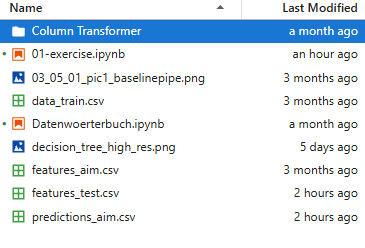

# **0. Gather Data**

In [ ]:
#import modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#suppress scientific notation and set to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#show all columns when e.g. using "describe"
pd.set_option('display.max_columns', None)

In [ ]:
#read data
df = pd.read_csv("data_train.csv")

# **1. EDA**

In [ ]:
#check head
df.head()

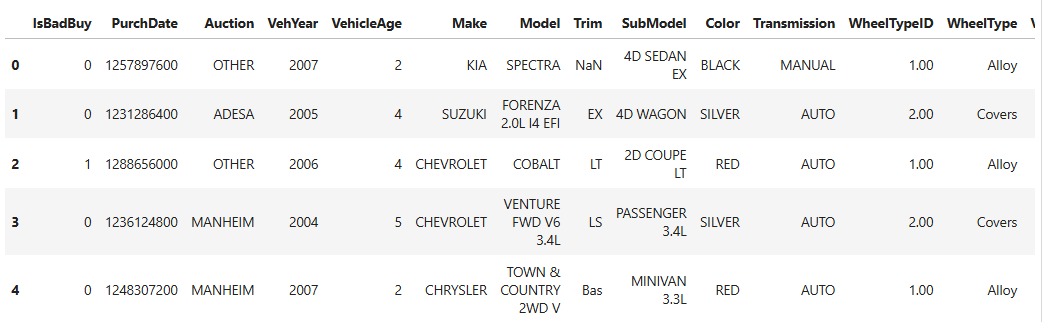

In [ ]:
#check describe
df.describe().T

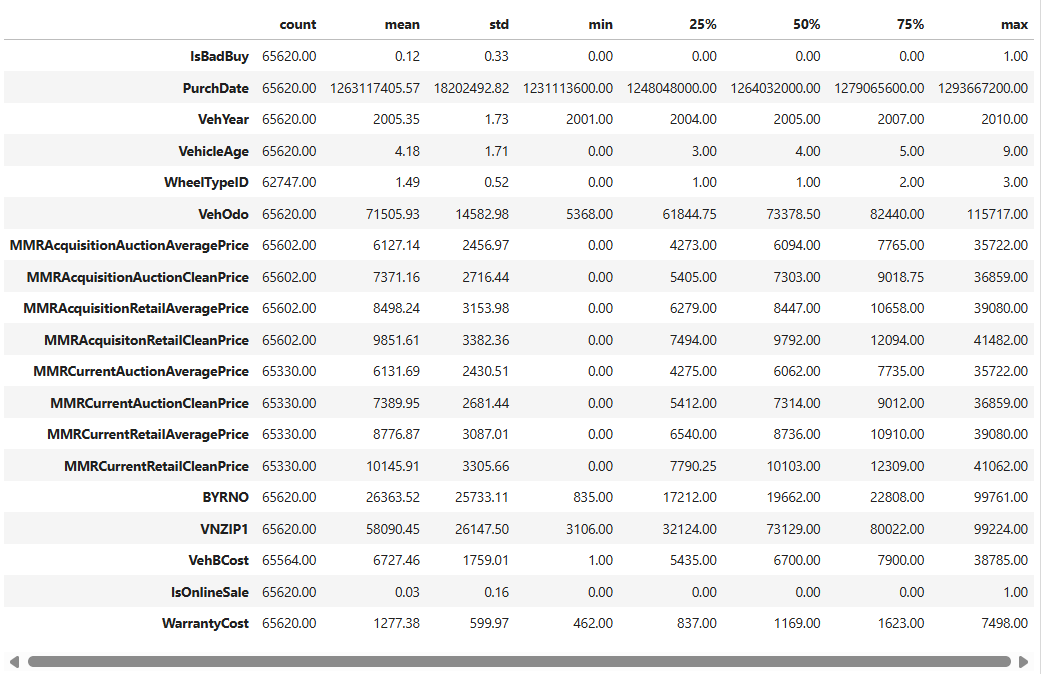

In [ ]:
#check for datatypes
df.info()

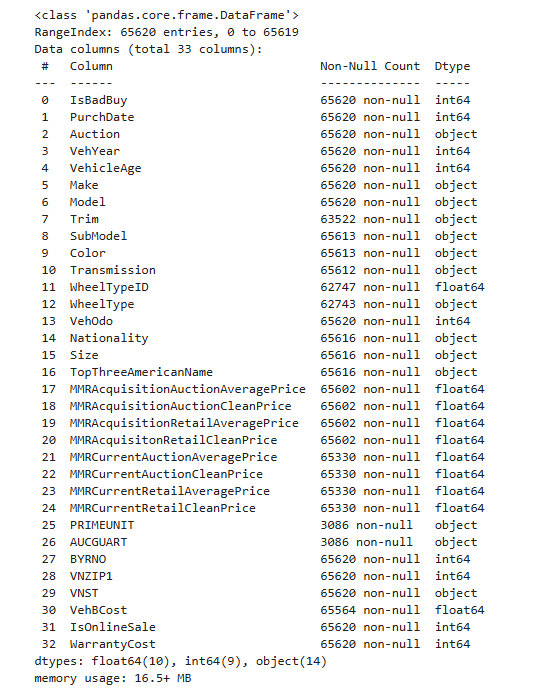

In [ ]:
#check nans, size, duplicates
nan_counts = df.isna().sum().sort_values(ascending=False)
display(nan_counts.to_frame(name="count"))
print("-" * 50)
print("Count of duplicates:", df.duplicated().sum())

#conclusion: no duplicates, but missing values -> Columns 'PRIMEUNIT', 'AUCGUART' can be removed (majority of values missing)

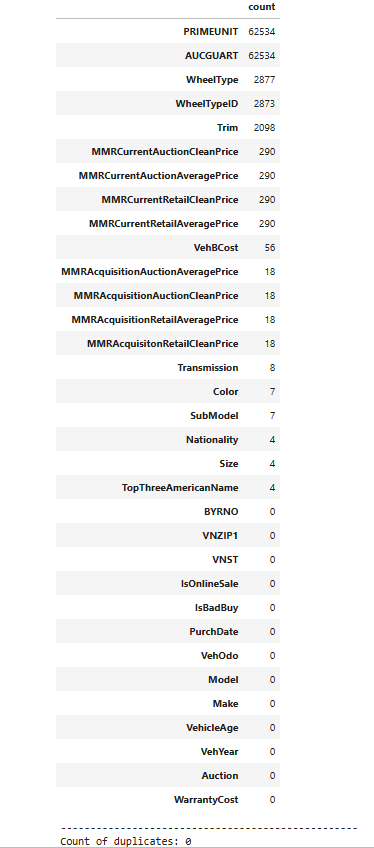

In [ ]:
#check objects and categories
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

#1. Counts
print("Unique value per categorical feature:")
unique_counts = df[categorical_cols].nunique().sort_values(ascending=False)
display(unique_counts.to_frame(name="Unique Values"))

#2. Creating plots
plt.figure(figsize=(12, 8))

#horizontal barplot
ax = sns.barplot(x=unique_counts.values, y=unique_counts.index, palette="magma")
ax.bar_label(ax.containers[0], padding=3)

#creating warnline
threshold = 50 
plt.axvline(x=threshold, color='red', linestyle='--', label=f'OHE Limit (~{threshold})')

plt.title("Unique value per categorical feature")
plt.xlabel("Count Unique Values")
plt.ylabel("Feature Name")
plt.legend()
plt.tight_layout()
plt.show()

#conclusion: remove and ignore columns 'Model','SubModel', 'Trim' -> too many different categories for One-Hot-Encoding (OHE)
#plotting categories below, but not 'Model','SubModel', 'Trim'

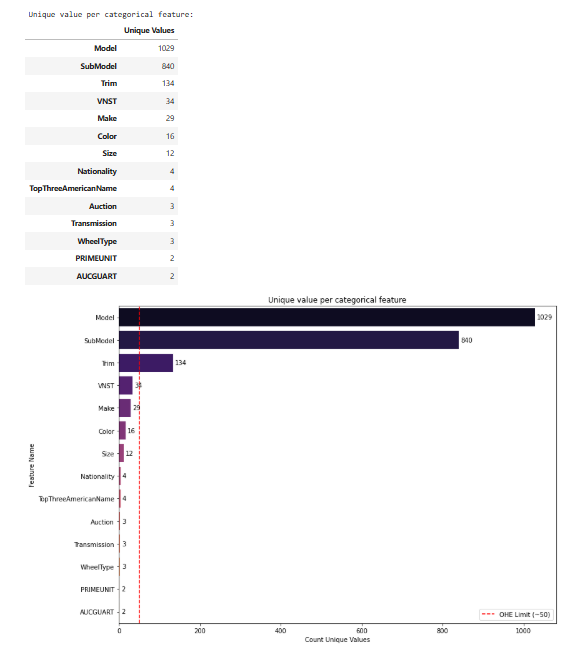

In [ ]:
#check distribution of objects and categories values of each feature, referring to target
#plotting categories below, but not 'Model','SubModel', 'Trim'

#A) all categorical columns (type 'object')
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

#B) ignore too many unique values/high cardinality)
ignore_cols = ['Model', 'SubModel', 'Trim']

#C) filtering: Keep only columns that are NOT in the ignore list
cat_cols = [col for col in cat_cols if col not in ignore_cols]

print(f"The following columns will be plotted: {cat_cols}")
print("-" * 50)

#plotting
# Colors: 0=Green (GoodBuy), 1=Red (BadBuy)
my_palette = {0: "tab:green", 1: "tab:red"}

for feature in cat_cols:
    plt.figure(figsize=(14, 6)) # Slightly wider for better readability
    
    # Create a temporary copy for the plot
    # We fill NaNs with 'MISSING' and convert to string to ensure clean plotting
    # fillna is safer than replace for actual NaNs here
    df_plot = df.copy()
    df_plot[feature] = df_plot[feature].fillna('MISSING').astype(str)
    
    #most frequent categories first (makes the plot easier to read)
    # We optionally limit to the top 30 values, just in case there are many categories
    top_categories = df_plot[feature].value_counts().index[:50]
    
    sns.countplot(
        data=df_plot[df_plot[feature].isin(top_categories)], 
        x=feature, 
        hue='IsBadBuy', 
        palette=my_palette,
        order=top_categories
    )
    
    plt.title(f'Distribution: {feature} (incl. Missing Values)', fontsize=15)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Vehicle Count', fontsize=12)
    plt.legend(title='IsBadBuy', labels=['Good Buy (0)', 'Bad Buy (1)'], loc='upper right')
    
    # Rotate x-axis labels so they don't overlap
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

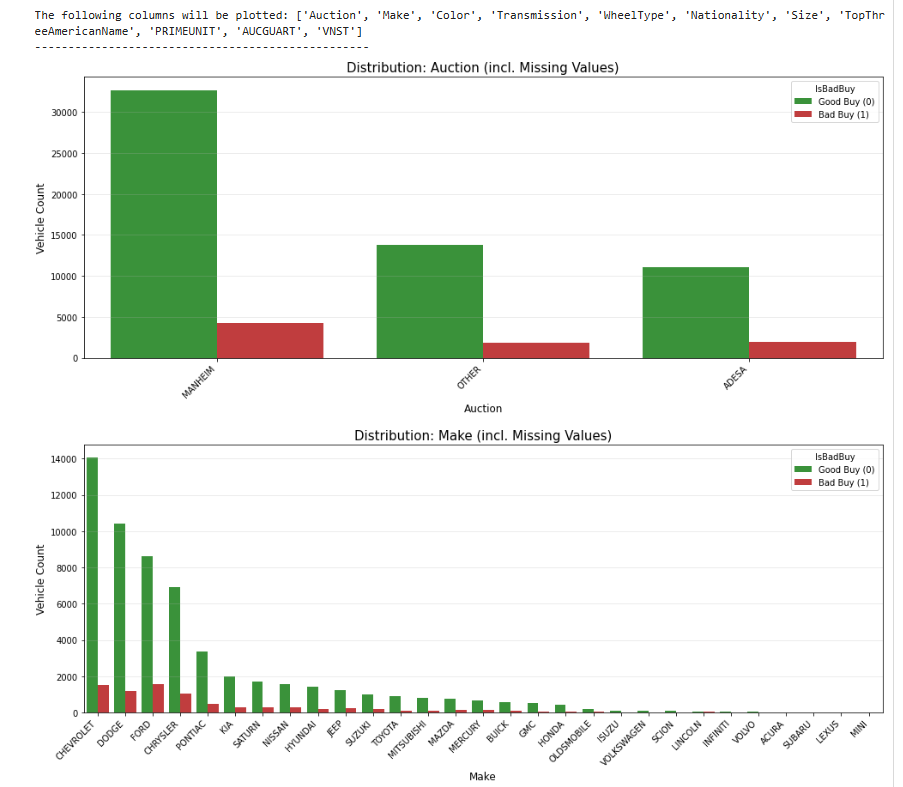
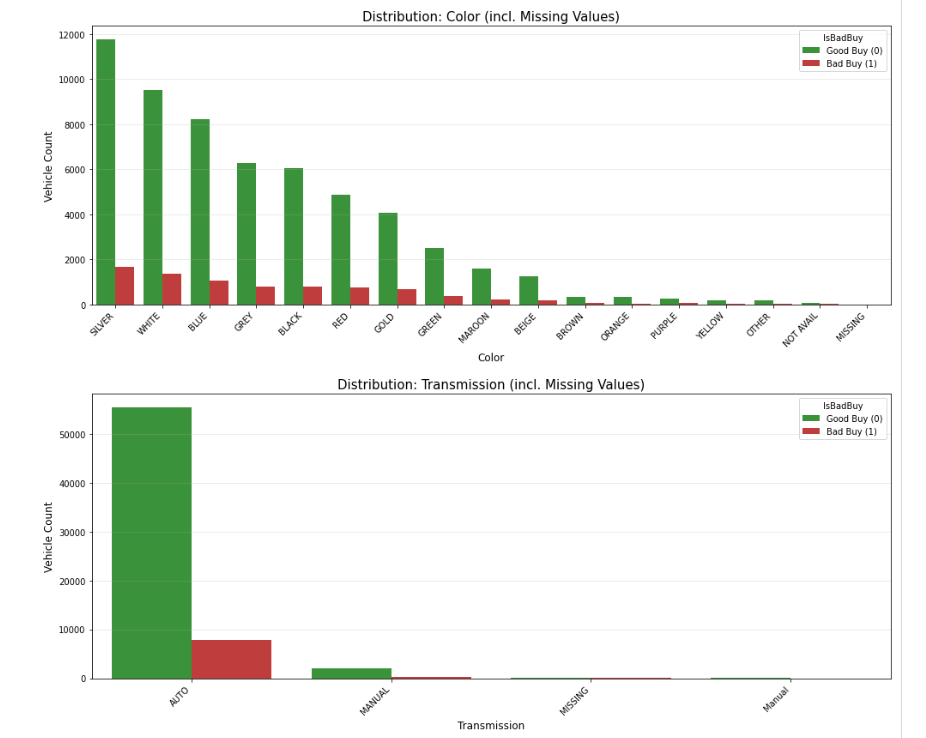

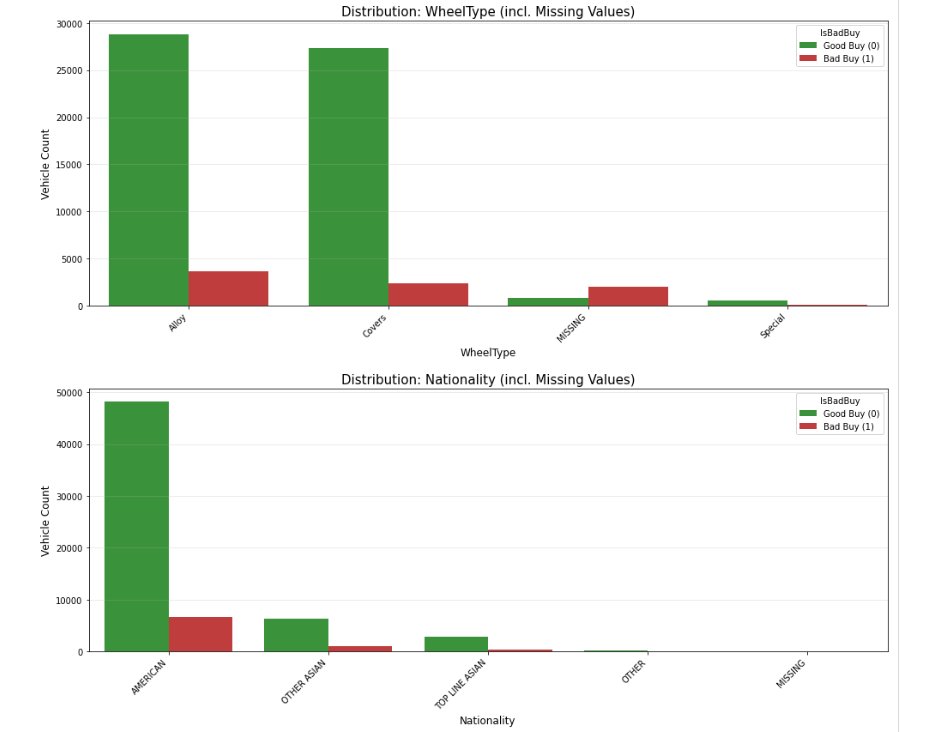
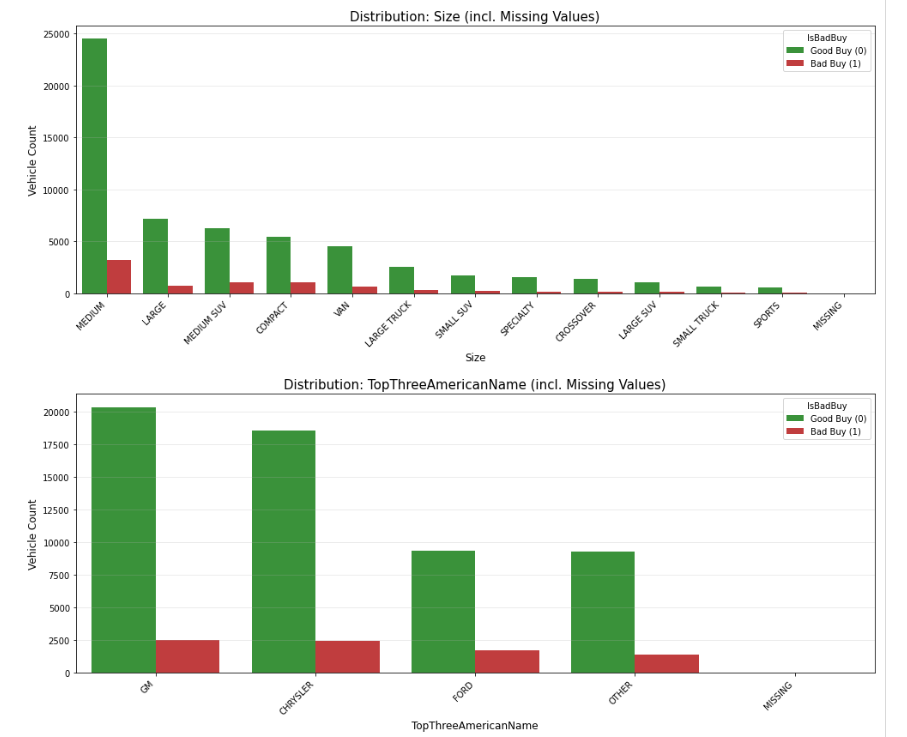
![image-3.png](attachment:image-3.png)

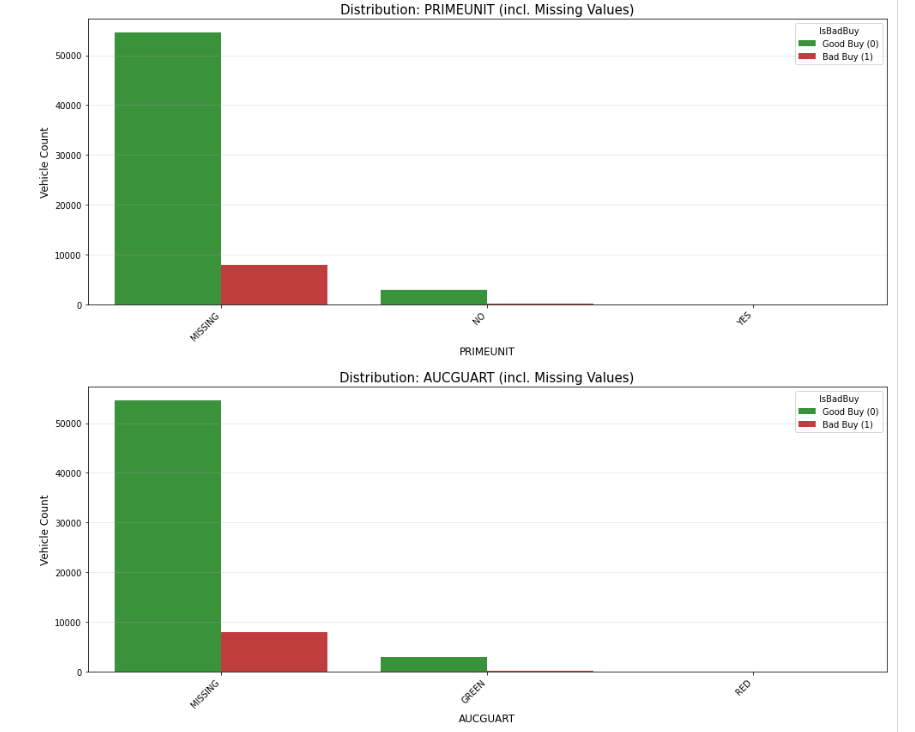
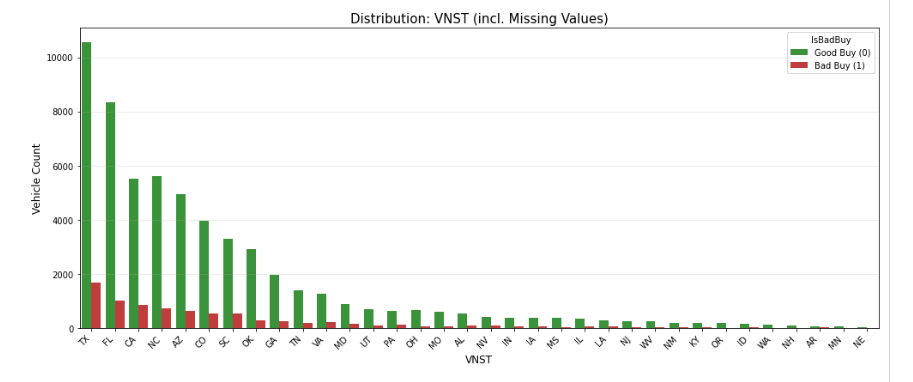

In [ ]:
#check distribution of numericical values of each feature

cols_to_plot = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
    'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
    'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
    'VehBCost', 'WarrantyCost', 'VehicleAge', 'VehOdo', 'IsBadBuy']
    #could also add 'VehicleAge' 
sns.pairplot(df[cols_to_plot], hue='IsBadBuy')

#conclusion: Prices correlate -> see center of the image and upcoming correlation matrix!

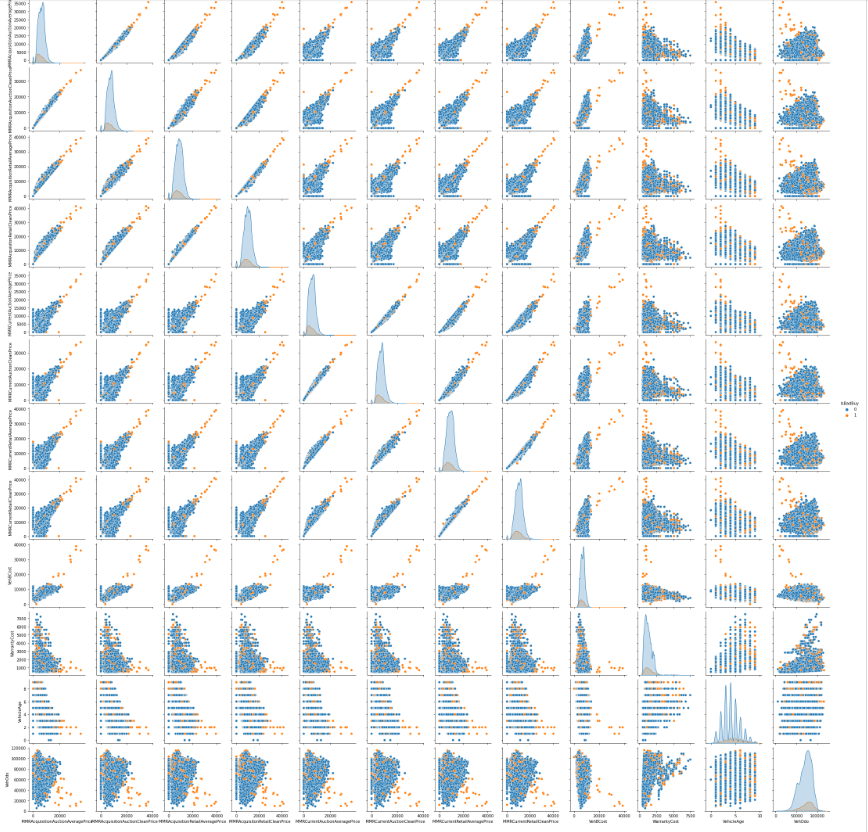

In [ ]:
#check distribution of numeric values -> outliers?
#1. Defining groups (because there are different scales)

#Odometer
odo_col = ['VehOdo']

#Age
age_col = ['VehicleAge']

#Prices and Costs
price_cols = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
    'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
    'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
    'VehBCost', 'WarrantyCost']

#2. Plotting Setup
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Plot A: Odometer
sns.boxplot(data=df[odo_col], ax=axes[0], palette="Blues")
axes[0].set_title("Outliers: Odometer (VehOdo)")

#Plot B: Prices and Costs 
sns.boxplot(data=df[price_cols], ax=axes[1], palette="Greens")
axes[1].set_title("Outliers: Prices & Costs")
axes[1].tick_params(axis='x', rotation=45) # Beschriftung drehen

#Plot C: Age
sns.boxplot(data=df[age_col], ax=axes[2], palette="Oranges")
axes[2].set_title("Outliers: Age")

plt.tight_layout()
plt.show()

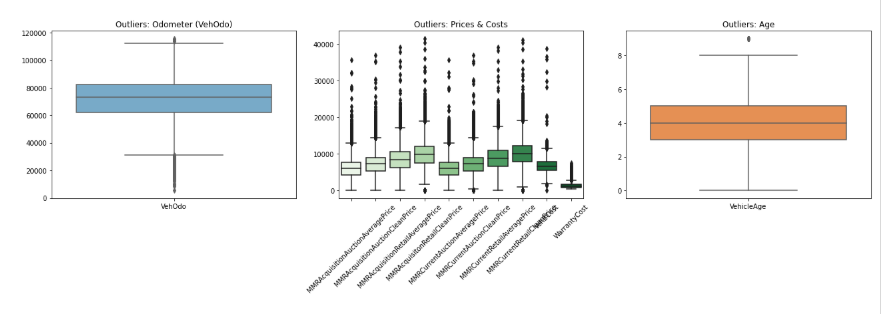

In [ ]:
#check correlations using Pearson Correlation
cor = df.corr()
cor_mask = np.triu(np.ones_like(cor, dtype=bool))

plt.figure(figsize=(16, 10))
sns.heatmap(cor, 
            mask=cor_mask,   #using mask
            annot=True,      #show numbers
            cmap='RdBu_r',   #color scheme
            center=0,        #setting white as center (0)
            vmin=-1, vmax=1, #fixing scale from -1 bis +1 for better comparison
            fmt=".4f",       #4 digits
            linewidths=0.5)  #little gaps between tiles
plt.show()

#conclusions: 
#Acquisition prices (MMR) correlate extremely -> Apply PCA! | 'VehYear' and 'VehicleAge' correlate extremely -> Remove one, 'cause redundant

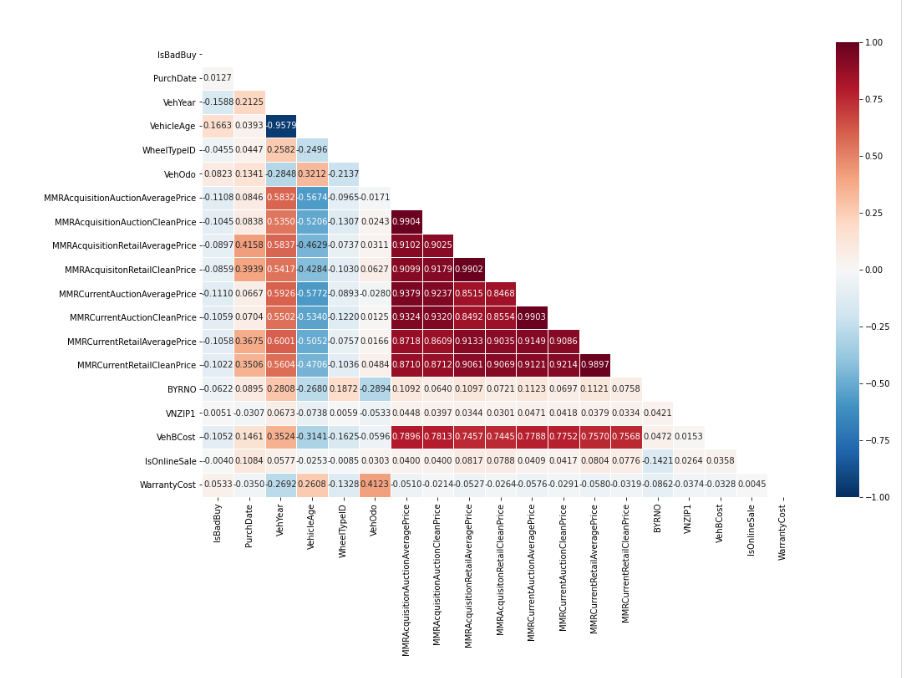

In [ ]:
#check for balancing of target
target_col = 'IsBadBuy'

count_tab = pd.crosstab(index=df[target_col], columns="Count")
percent_tab = pd.crosstab(index=df[target_col], columns="Percentage (%)", normalize='all') * 100

#defining colors
my_palette = {0: "tab:green", 1: "tab:red"}

#plotting setup
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Plot 1: Absolute count
sns.barplot(x=count_tab.index, y=count_tab["Count"], palette=my_palette, ax=axes[0])
axes[0].set_title("Absolute Distribution")
axes[0].bar_label(axes[0].containers[0]) 

#Plot 2: Percentage
sns.barplot(x=percent_tab.index, y=percent_tab["Percentage (%)"], palette=my_palette, ax=axes[1])
axes[1].set_title("Percentage Distribution")
axes[1].set_ylim(0, 110)
axes[1].bar_label(axes[1].containers[0], fmt='%.1f%%')

plt.tight_layout()
plt.show()

#conclusion: Targets are NOT balanced -> should be regarded within model via balancing!

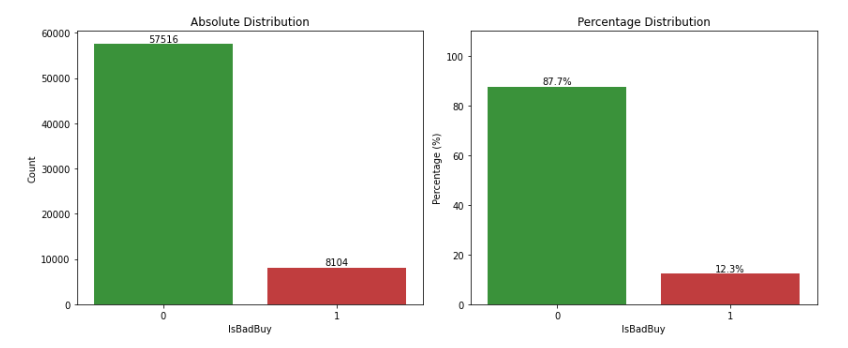

# **2. Train-Test-Split**

In [ ]:
#read in the dataframe again to remove previous changes
df = pd.read_csv("data_train.csv")

In [ ]:
#check shape BEFORE train-test-split
df.shape

#(65620, 33)

In [ ]:
#perform train-test-split
from sklearn.model_selection import train_test_split

target = df.loc[:,'IsBadBuy']
features = df.drop('IsBadBuy', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

In [ ]:
#save features_test as 'features_test.csv'
features_test.to_csv('features_test.csv', index=False)

In [ ]:
#copy target_train
df = features_train.copy()

In [ ]:
#check shape AFTER train-test-split
df.shape

#(59058, 32)

# **3. Data Preparation**

In [ ]:
#convert time data to date format
#convert ordinal data to integer ->no ordinals here
#convert nominal data to Boolean data
#clean up metric data if necessary or convert to float/int

In [ ]:
#change datetime
df.loc[:, 'PurchDate'] = pd.to_datetime(df.loc[:, 'PurchDate'], unit='s')

#change numeric values to save RAM 
#'UInt8/16' can change datatype although there are NaN values ('uint8', 'uint16' can not)
df['VehYear'] = df['VehYear'].astype('UInt16')  
df['VehicleAge'] = df['VehicleAge'].astype('UInt8') #values <255
df['MMRAcquisitionAuctionAveragePrice'] = df['MMRAcquisitionAuctionAveragePrice'].astype('UInt16') 
df['MMRAcquisitionAuctionCleanPrice'] = df['MMRAcquisitionAuctionCleanPrice'].astype('UInt16') 
df['MMRAcquisitionRetailAveragePrice'] = df['MMRAcquisitionRetailAveragePrice'].astype('UInt16') 
df['MMRAcquisitonRetailCleanPrice'] = df['MMRAcquisitonRetailCleanPrice'].astype('UInt16') 
df['MMRCurrentAuctionAveragePrice'] = df['MMRCurrentAuctionAveragePrice'].astype('UInt16') 
df['MMRCurrentAuctionCleanPrice'] = df['MMRCurrentAuctionCleanPrice'].astype('UInt16') 
df['MMRCurrentRetailAveragePrice'] = df['MMRCurrentRetailAveragePrice'].astype('UInt16') 
df['MMRCurrentRetailCleanPrice'] = df['MMRCurrentRetailCleanPrice'].astype('UInt16') 
df['VehBCost'] = df['VehBCost'].astype('UInt16') 
df['WarrantyCost'] = df['WarrantyCost'].astype('UInt16') 
df['IsOnlineSale'] = df['IsOnlineSale'].astype('UInt8')

#change object to category
df['Auction'] = df['Auction'].astype('category')
df['Make'] = df['Make'].astype('category')
df['Model'] = df['Model'].astype('category')
df['Trim'] = df['Trim'].astype('category')
df['SubModel'] = df['SubModel'].astype('category')
df['Color'] = df['Color'].astype('category')
df['Transmission'] = df['Transmission'].astype('category')
df['WheelTypeID'] = df['WheelTypeID'].astype('category')
df['WheelType'] = df['WheelType'].astype('category')
df['Nationality'] = df['Nationality'].astype('category')
df['Size'] = df['Size'].astype('category')
df['TopThreeAmericanName'] = df['TopThreeAmericanName'].astype('category')
df['PRIMEUNIT'] = df['PRIMEUNIT'].astype('category')
df['AUCGUART'] = df['AUCGUART'].astype('category')
df['BYRNO'] = df['BYRNO'].astype('category')
df['VNZIP1'] = df['VNZIP1'].astype('category')
df['VNST'] = df['VNST'].astype('category')

In [ ]:
#checking datatypes after changes
df.info()

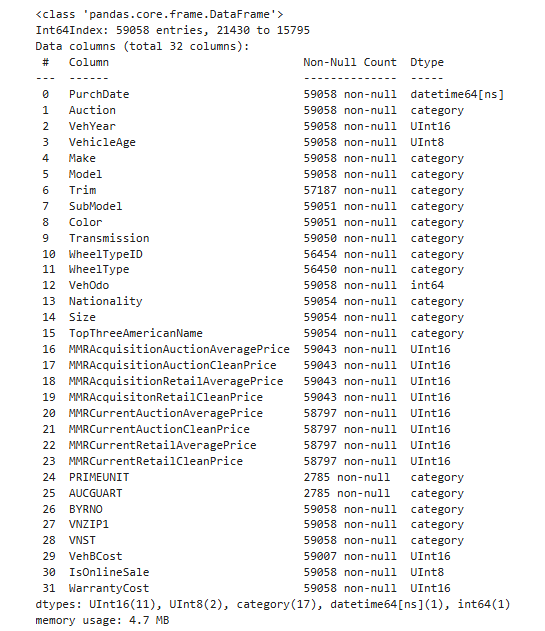

In [ ]:
#sanity check: 'WheelTypeID' belongs to which 'WheelType'

wheel_check = pd.crosstab(index=df['WheelTypeID'], 
                          columns=df['WheelType'], 
                          dropna=False) #dropna=False also shows where values are missing

print("--- Does 'WheelTypeID' fit the 'WheelType'? ---")
display(wheel_check)

#conclusion: 'WheelTypeID' fits'WheelType'! -> WheelTypeID can be removed later (redundant data) 

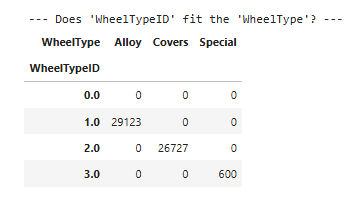

In [ ]:
#sanity check: Is 'PurchDate' > 'VehYear'?

#extract purch year
df['PurchYear'] = df['PurchDate'].dt.year

#calculating calculated age
# Formel: PurchYear - VehYear
df['Calculated_Age_Check'] = df['PurchYear'] - df['VehYear']

#'PurchDate' < 'VehYear'?
#A value of -1 is often still acceptable (model year phenomenon: 2010 models are sold at the end of 2009)
#But anything less than -1 is definitely a data error

time_travelers = df[df['Calculated_Age_Check'] < -1]

print(f"Number of impossible purchase dates (purchase before year of manufacture): {len(time_travelers)}")

if len(time_travelers) > 0:
    print("\nExample of 'time-traveling' cars:")
    display(time_travelers[['VehYear', 'PurchDate', 'VehicleAge', 'Calculated_Age_Check']].head())
else:
    print("Okay. No car was sold before its production.")
    
#conclusion: No logical error

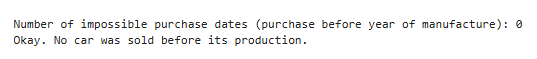

In [ ]:
#numerical values seem to be feasible and no logical errors (wheel-types and car age)

In [ ]:
#defining cleaning function -> but is not used (could be integrated)

def clean_data(df):
    """Returns cleaned DataFrame.
    
    Transform datatypes:
        -transform 'PurchDate' to datetime format
        -transform numeric values to save RAM
    
    Args: 
        df (pd.DataFrame) : uncleaned DataFrame
        
    Returns:
        df  (pd.DataFrame) : cleaned DataFrame
    
    """
   #change datetime
    df.loc[:, 'PurchDate'] = pd.to_datetime(df.loc[:, 'PurchDate'], unit='s')

    #change numeric values to save RAM 
    #'UInt8/16' can change datatype although there are NaN values ('uint8', 'uint16' can not)
    df['VehYear'] = df['VehYear'].astype('UInt16')  
    df['VehicleAge'] = df['VehicleAge'].astype('UInt8') #values <255
    df['MMRAcquisitionAuctionAveragePrice'] = df['MMRAcquisitionAuctionAveragePrice'].astype('UInt16') 
    df['MMRAcquisitionAuctionCleanPrice'] = df['MMRAcquisitionAuctionCleanPrice'].astype('UInt16') 
    df['MMRAcquisitionRetailAveragePrice'] = df['MMRAcquisitionRetailAveragePrice'].astype('UInt16') 
    df['MMRAcquisitonRetailCleanPrice'] = df['MMRAcquisitonRetailCleanPrice'].astype('UInt16') 
    df['MMRCurrentAuctionAveragePrice'] = df['MMRCurrentAuctionAveragePrice'].astype('UInt16') 
    df['MMRCurrentAuctionCleanPrice'] = df['MMRCurrentAuctionCleanPrice'].astype('UInt16') 
    df['MMRCurrentRetailAveragePrice'] = df['MMRCurrentRetailAveragePrice'].astype('UInt16') 
    df['MMRCurrentRetailCleanPrice'] = df['MMRCurrentRetailCleanPrice'].astype('UInt16') 
    df['VehBCost'] = df['VehBCost'].astype('UInt16') 
    df['WarrantyCost'] = df['WarrantyCost'].astype('UInt16') 
    df['IsOnlineSale'] = df['IsOnlineSale'].astype('UInt8')

    #change object to category
    df['Auction'] = df['Auction'].astype('category')
    df['Make'] = df['Make'].astype('category')
    df['Model'] = df['Model'].astype('category')
    df['Trim'] = df['Trim'].astype('category')
    df['SubModel'] = df['SubModel'].astype('category')
    df['Color'] = df['Color'].astype('category')
    df['Transmission'] = df['Transmission'].astype('category')
    df['WheelTypeID'] = df['WheelTypeID'].astype('category')
    df['WheelType'] = df['WheelType'].astype('category')
    df['Nationality'] = df['Nationality'].astype('category')
    df['Size'] = df['Size'].astype('category')
    df['TopThreeAmericanName'] = df['TopThreeAmericanName'].astype('category')
    df['PRIMEUNIT'] = df['PRIMEUNIT'].astype('category')
    df['AUCGUART'] = df['AUCGUART'].astype('category')
    df['BYRNO'] = df['BYRNO'].astype('category')
    df['VNZIP1'] = df['VNZIP1'].astype('category')
    df['VNST'] = df['VNST'].astype('category')
   

    return df

In [ ]:
#defining sampling function -> but is not used (could be integrated)
def sampling_data(features, target):
    """Sample Dataframe.
    Only keeping datapoints that are not outliers.
    In the dataset doesn't seem to be outliers
    """
    return features, target

In [ ]:
#defining engineer_features function -> but is not used (could be integrated)
def engineer_features(df):
    """Add new Features to Dataframe.
    Args:
        df (pd.DataFrame): Dataframe
    Returns:
        (pd.DataFrame) : Dataframe with new Features
    """     
    #drop unnecessary columns
    df = df.drop(['Model','SubModel', 'Trim', 'WheelTypeID', 'BYRNO', 'PRIMEUNIT', 'AUCGUART'], axis = 1)

    return df

# **4. Modeling**

In [ ]:
#check features which could be regarded at this point
total_cols = len(df.columns)

print(f"Feature count: {total_cols}")
print("-" * 30)

for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

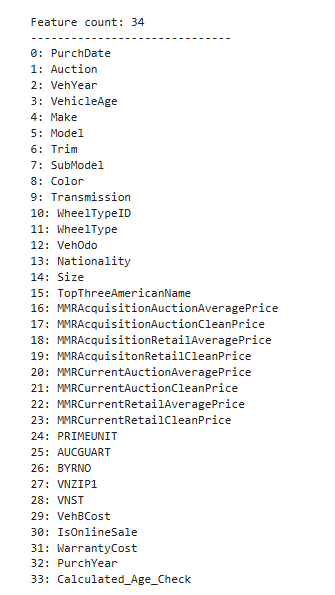

# **4.1 Baseline model**

In [ ]:
#1st model: baseline model (Logistic Regression)

#feature engineering (only for baseline model): 'MilesPerYear'
features_train['MilesPerYear'] = features_train['VehOdo'] / np.maximum(features_train['VehicleAge'], 1)
features_test['MilesPerYear'] = features_test['VehOdo'] / np.maximum(features_test['VehicleAge'], 1)
feature_cols = ['VehicleAge', 'VehOdo', 'IsOnlineSale', 'WarrantyCost', 'MilesPerYear']

#instantiate model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix

#select features
features_train_copy = features_train.loc[:, feature_cols]
features_test_copy = features_test.loc[:, feature_cols]

#build pipeline
logreg_pipeline = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("logistic_regression", LogisticRegression(
        random_state=42, 
        n_jobs=-1,              #all processor cores
        class_weight='balanced' #balancing because target is NOT balanced -> could improve F1
    ))
])

#fit pipeline on training set
logreg_pipeline.fit(features_train_copy, target_train)

#predict and evaluate on test set
logreg_predictions = logreg_pipeline.predict(features_test_copy)

print("Logistic Regression (Classification)\n------------------------------------")
f1 = f1_score(target_test, logreg_predictions)
print(f"F1 Score (binär): {f1:.4f}")
print('Precision: ', precision_score(target_test, logreg_predictions))
print('Recall: ', recall_score(target_test, logreg_predictions))
print('Roc-Auc: ', roc_auc_score(target_test, logreg_predictions))
print('Accuracy: ', accuracy_score(target_test, logreg_predictions))

print("\nDetail-Report:")
print(classification_report(target_test, logreg_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(target_test, logreg_predictions))

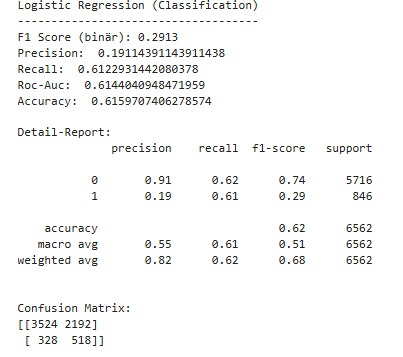

In [ ]:
#see EDA (nunique categories) -> should remove 'SubModel', 'Model', 'Trim' 'cause there are too many different categories
#check objects
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("Unique value per feature:")
unique_counts = df[categorical_cols].nunique().sort_values(ascending=False)
display(unique_counts.to_frame(name="Unique Values"))
#conclusion: should remove columns 'Model','SubModel', 'Trim' -> too many for OHE

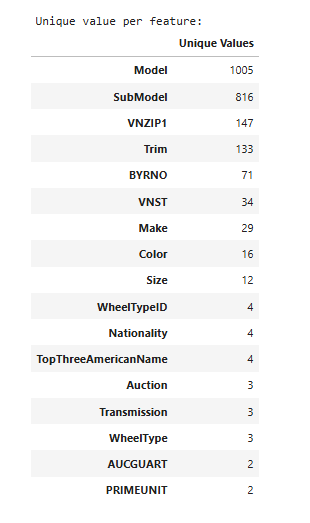

In [ ]:
#using this list for OHE (will be used below)
#ohe_list = ['Auction', 'Make', 'Color', 'WheelType', 'TopThreeAmericanName', 'Nationality']

In [ ]:
#evaluate baseline model - feature importance
#retrieving model from pipeline
model = logreg_pipeline.named_steps['logistic_regression']

#get the coefficients (model.coef_ is a 2D array, need of the first element)
coefficients = model.coef_.flatten()

#use dataframe for nicer visualization
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Importance': np.abs(coefficients)
})

#sort by absolute importance (strength of influence)
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

print("Feature Importance (Coefficients):")
display(feature_importance[['Feature', 'Coefficient']])

plt.figure(figsize=(10, 6))

#define colors: Red for risk (positive), green for safety (negative)
colors = ['red' if c > 0 else 'green' for c in feature_importance['Coefficient']]

plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title('Influence of features on "IsBadBuy" (Logistic Regression)')
plt.xlabel('Coefficient (Standardized)')
plt.ylabel('Feature')
plt.show()

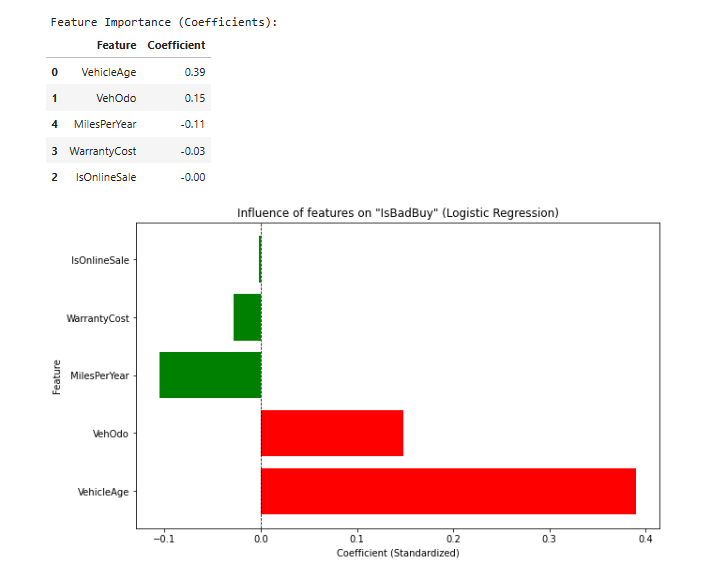

# **4.2 Train and evaluate different models**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#prices according to correlation matrix above will be reduced!

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [ ]:
#useful imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report

# importing modules for data preparation
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# importing modules for training
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

# importing modules for pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# importing modules for hyperparameter optimization and comparison of models
from sklearn.model_selection import validation_curve, learning_curve

# shut off some annoying warnings ;-) 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
#check features which could be regarded at this point (also used for upcoming models)
len(df.columns)

print(f"Feature count: {total_cols}")
print("-" * 30)

for i, col in enumerate(df.columns):
    print(f"{i}: {col}")


#defining and choosing features for testing and following ML-models
keep_cols = ['IsOnlineSale']
impute_list = ['Color', 'WheelType', 'TopThreeAmericanName', 'Nationality']
ohe_list = ['Auction', 'Make', 'Color', 'WheelType', 'TopThreeAmericanName', 'Nationality']
scale_list = ['VehOdo', 'VehicleAge', 'WarrantyCost', 'VehBCost']
pca_list = [
    'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
    'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
    'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice'
            ]

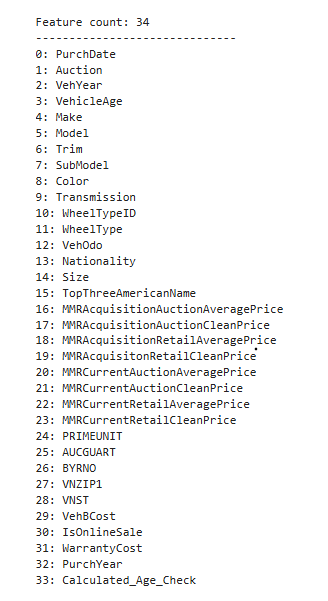

In [ ]:
#2nd model: logistic regression (unoptimized model)

#creating a pipeline first for each step

#pipeline for standardization of numeric features (OHE does not need to get standardized)
#A) Pipeline for numeric features (scaling only)
numeric_transformer = Pipeline(steps=[
    ('fix_typo', FunctionTransformer(lambda x: x.replace('Manual', 'MANUAL'), validate=False)), #one line transmission with 'Manual'
    ('imputer', SimpleImputer(strategy='median')), #missing values imputing with median
    ('scaler', StandardScaler()) #scaling
])

#B) Pipeline for categories (imputation + OHE)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#C) Pipeline für MMR-columns (imputation + scaling + PCA)
pca_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #1. Missing values imputing with median
    ('scaler', StandardScaler()),                  #2. Scaling (important for PCA!)
    ('pca', PCA(n_components=1))                   #3. One PC
])

#Instantiating columntransformer to define which columns for which pipeline step
preprocessor = ColumnTransformer(
    transformers=[
        #name, transformer, feature lists
        ('num', numeric_transformer, scale_list),
        ('cat', categorical_transformer, ohe_list),
        ('pca', pca_transformer, pca_list),    
        ('keep', 'passthrough', keep_cols)
    ],
    remainder='drop' #deleting remaining
)

#Instantiating final pipeline with preprocessor and model (logreg)
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', LogisticRegression(
        solver='liblinear', 
        class_weight='balanced', #balancing, cause target is not balanced!
        random_state=42
    ))
])

#fitting and predicting pipeline with logistic regression
pipeline_lr.fit(features_train, np.ravel(target_train))
target_test_pred = pipeline_lr.predict(features_test)

print('F1: ', f1_score(target_test, target_test_pred))
print('Precision: ', precision_score(target_test, target_test_pred))
print('Recall: ', recall_score(target_test, target_test_pred))
print('Roc-Auc: ', roc_auc_score(target_test, target_test_pred))
print('Accuracy: ', accuracy_score(target_test, target_test_pred))

print("\nDetail-Report:")
print(classification_report(target_test, target_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(target_test, target_test_pred))

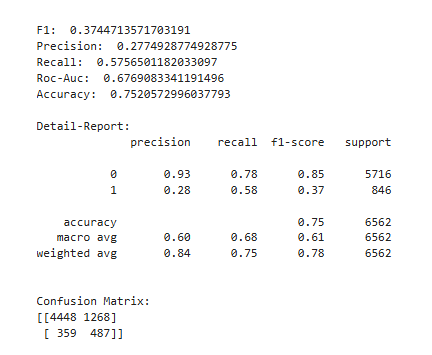

In [ ]:
#2nd model (log reg) feature importance

#retrieving model from pipeline
model = pipeline_lr.named_steps['model']
preprocessor = pipeline_lr.named_steps['preprocessor']

#extract feature names
coefficients = model.coef_.flatten()
feature_names = []

#A) Numeric features
feature_names.extend(scale_list)

#B) PCA columns
try:
    pca_step = preprocessor.named_transformers_['pca'].named_steps['pca']
    n_pca = pca_step.n_components_
    feature_names.extend([f"MMR_PCA_{i}" for i in range(n_pca)])
except:
    feature_names.append("MMR_PCA_0")

#C) Remaining columns
feature_names.extend(keep_cols)

#D) Categorical columns (OHE)
try:
    ohe_step = preprocessor.named_transformers_['cat'].named_steps['ohe']
    ohe_names = ohe_step.get_feature_names(ohe_list)
    feature_names.extend(ohe_names)
except:
    missing = len(coefficients) - len(feature_names)
    feature_names.extend([f"Cat_Feature_{i}" for i in range(missing)])

#creating dataframe
df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Importance': np.abs(coefficients)
})

#sorting: Most important features first
df_imp = df_imp.sort_values(by='Abs_Importance', ascending=True)

num_features = len(df_imp)
plot_height = max(6, num_features * 0.3)
plt.figure(figsize=(12, plot_height))

colors = ['red' if c > 0 else 'green' for c in df_imp['Coefficient']]
plt.barh(df_imp['Feature'], df_imp['Coefficient'], color=colors)

plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'All {len(df_imp)} Features (Logistic Regression)', fontsize=14)
plt.xlabel('Coefficient (Importance)', fontsize=12)
plt.yticks(fontsize=9)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"--- Table of all {len(df_imp)} Features ---")

df_table = df_imp.sort_values(by='Abs_Importance', ascending=False)

#setting pandas option to show all rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_table)
    
#1. Calculate Business Metric: "Odds Ratio"
# Formula: e^(Coefficient) - 1 = Percentage change in risk
# Example: Coeff 0.4 -> exp(0.4) = 1.49 -> +49% higher risk
df_imp['Change_in_Odds_%'] = (np.exp(df_imp['Coefficient']) - 1) * 100

# Reload lists with the new metric
top_risk = df_imp.sort_values(by='Coefficient', ascending=False).head(10)
top_safe = df_imp.sort_values(by='Coefficient', ascending=True).head(10)

#2. Extended Plot with Percentages
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- PLOT 1: The Risk Drivers (RED) ---
bars_risk = axes[0].barh(top_risk['Feature'], top_risk['Coefficient'], color='#d62728', alpha=0.8)
axes[0].set_title('Top 10 Risk Drivers', fontsize=16, pad=20)
axes[0].set_xlabel('Log-Odds (Model Influence)', fontsize=12)
axes[0].invert_yaxis()

#adding percentage labels
for bar, pct in zip(bars_risk, top_risk['Change_in_Odds_%']):
    width = bar.get_width()
    label = f"+{pct:.0f}% Risk" # e.g., "+50% Risk"
    axes[0].text(width, bar.get_y() + bar.get_height()/2, 
                 f'  {label}', 
                 va='center', fontweight='bold', color='darkred')

# --- PLOT 2: The Safety Factors (GREEN) ---
# We plot the absolute coefficient so bars go to the right
bars_safe = axes[1].barh(top_safe['Feature'], top_safe['Abs_Importance'], color='#2ca02c', alpha=0.8)
axes[1].set_title('Top 10 Safety Factors', fontsize=16, pad=20)
axes[1].set_xlabel('Magnitude of Influence', fontsize=12)
axes[1].invert_yaxis()

#adding percentage labels
for bar, pct in zip(bars_safe, top_safe['Change_in_Odds_%']):
    width = bar.get_width()
    # pct is negative here (e.g., -30%), which is correct
    label = f"{pct:.0f}% Risk" # e.g., "-25% Risk"
    axes[1].text(width, bar.get_y() + bar.get_height()/2, 
                 f'  {label}', 
                 va='center', fontweight='bold', color='darkgreen')

plt.tight_layout()
plt.show()

#3. Print Text Summary for Presentation
print("--- Business Translation for Management ---")
print("Top 3 Warning Signals:")
for i in range(3):
    row = top_risk.iloc[i]
    print(f"  • {row['Feature']}: Increases the chance of a bad buy by {row['Change_in_Odds_%']:.1f}%")

print("\nTop 3 Reassuring Factors:")
for i in range(3):
    row = top_safe.iloc[i]
    print(f"  • {row['Feature']}: Decreases the risk by {abs(row['Change_in_Odds_%']):.1f}%")

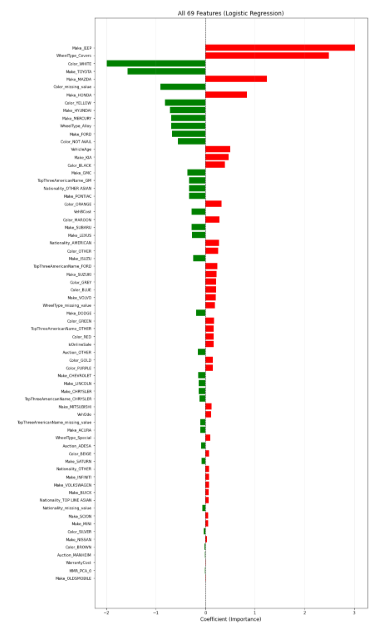
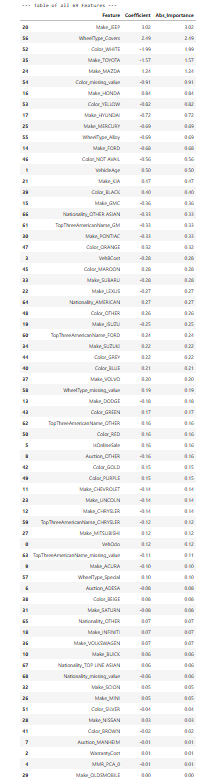
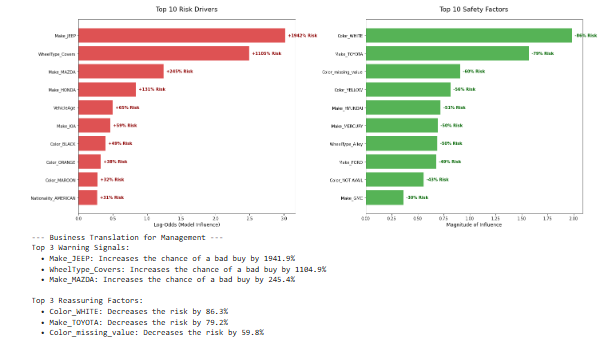

In [ ]:
#tune hyperparameters for 2nd model (Log Reg)

#defining grid
param_grid = {
    # --- Logistic Regression Tuning ---
    #C: Inverse regularization strength (small = greatly simplified, large = more complex/accurate on train)
    'model__C': [0.01, 0.1, 1, 10, 100],
    
    #Penalty: Type of regularization (l1 = Feature Selection, l2 = Shrink weights)
    'model__penalty': ['l1', 'l2'],
    
    # --- PCA Tuning ---
    # Path: preprocessor -> pca (Name im ColTrans) -> pca (Name in Pipeline) -> n_components
    'preprocessor__pca__pca__n_components': [1, 2, 3] 
}

#configure GridSearch
grid_search = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid,
    cv=5,               #5-Fold Cross Validation (more robust)
    scoring='f1',       #F1-Score (Balance)
    n_jobs=-1,          #all CPU cores
    verbose=1           #showing progress
)

#start searching (Training)
print("Start GridSearch...")
grid_search.fit(features_train, np.ravel(target_train))

#results
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

#apply best model on test data
best_model = grid_search.best_estimator_
target_test_pred_tuned = best_model.predict(features_test)

#report
print("\n--- Result based on test data ---")
print('F1: ', f1_score(target_test, target_test_pred_tuned))
print('Recall: ', recall_score(target_test, target_test_pred_tuned))
print('Precision: ', precision_score(target_test, target_test_pred_tuned))

print("\nConfusion Matrix:")
print(confusion_matrix(target_test, target_test_pred_tuned))

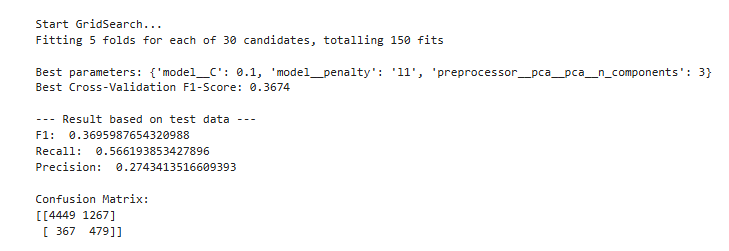

In [ ]:
#3rd model: Decision tree (simplified version)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

#chosing features
feature_cols = ['VehicleAge', 'VehOdo', 'WarrantyCost']
features_train_copy = features_train.loc[:, feature_cols]
features_test_copy = features_test.loc[:, feature_cols]

#setting-up pipeline
dt_pipeline = Pipeline([
    ("decision_tree", DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced', #because data is not balanced
        max_depth=3,
        #min_samples_leaf=20
    ))
])

#training
dt_pipeline.fit(features_train_copy, target_train)

#prediction
dt_predictions = dt_pipeline.predict(features_test_copy)

#evaluation
print("Decision Tree (simplified version)\n------------------------------------")
print(f"F1 Score: {f1_score(target_test, dt_predictions):.4f}")
print('Precision: ', precision_score(target_test, dt_predictions))
print('Recall: ', recall_score(target_test, dt_predictions))
print('Roc-Auc: ', roc_auc_score(target_test, dt_predictions))
print('Accuracy: ', accuracy_score(target_test, dt_predictions))

print("\nDetail-Report:")
print(classification_report(target_test, dt_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(target_test, dt_predictions))


#accessing trained model from pipeline
model_to_plot = dt_pipeline.named_steps['decision_tree']

#plotting Setup
plt.figure(figsize=(24, 12)) 

#plotting the tree
plot_tree(model_to_plot, 
          feature_names=feature_cols,   
          class_names=['Good (0)', 'Bad (1)'], 
          filled=True,                  
          rounded=True,                 
          fontsize=11,                 
          precision=2                   
)

plt.title("Decision Rules of simplified Decision Tree", fontsize=16)
plt.show()

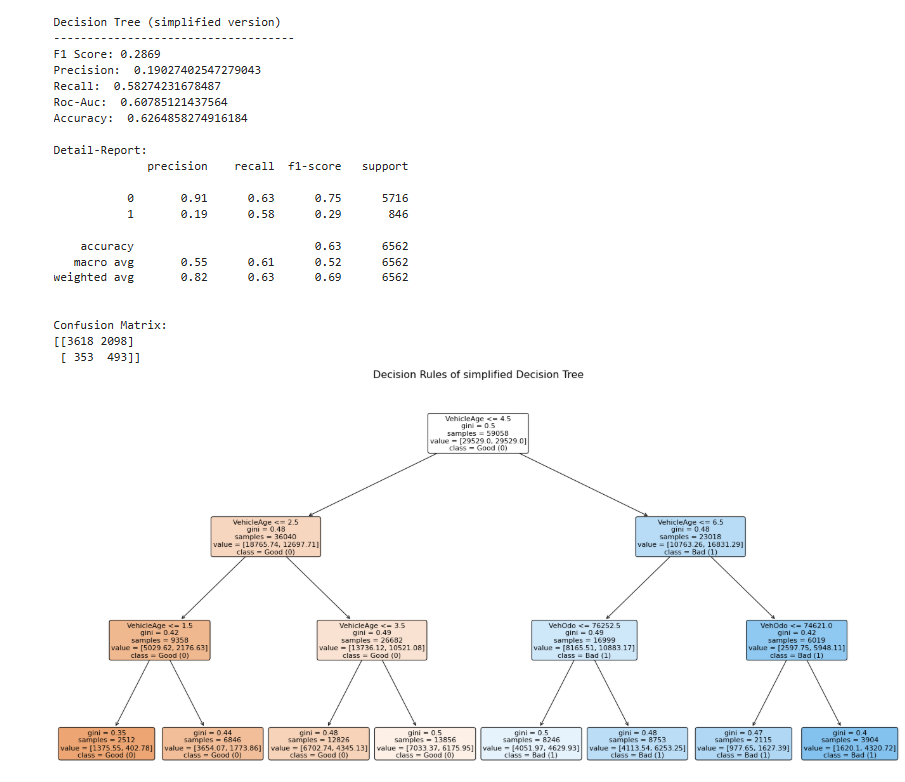

In [ ]:
#4th model: Decision tree (unoptimized model)

#defining pipeline
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(
        class_weight='balanced',
        random_state=42,
        max_depth=4,             
        min_samples_leaf=20      
    ))
])

#training
print("Start Training with Decision Tree...")
pipeline_dt.fit(features_train, np.ravel(target_train))
target_test_pred = pipeline_dt.predict(features_test)

#results
print('--- Decision Tree Results ---')
print('F1: ', f1_score(target_test, target_test_pred))
print('Recall: ', recall_score(target_test, target_test_pred))
print('Precision: ', precision_score(target_test, target_test_pred))
print('Accuracy: ', accuracy_score(target_test, target_test_pred))

print("\nDetail-Report:")
print(classification_report(target_test, target_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(target_test, target_test_pred))

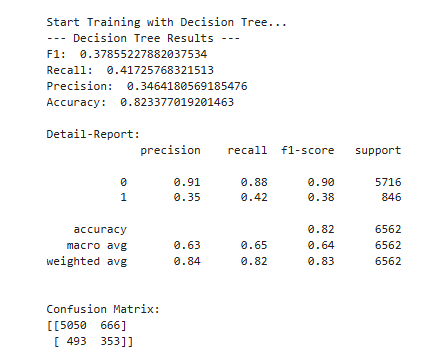

In [ ]:
#Optimizing Decision tree (+GridSearch)

#new pipeline with decision Tree
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', DecisionTreeClassifier(random_state=42))
])

#defining grid
param_grid = {
    # --- Decision Tree Tuning ---
    
    #depth of the tree: How many decisions?
    #None = Unlimited (maybe leads to overfitting!), 5-10 = conservative, 15-20 = complex
    'model__max_depth': [5, 10, 15, None],
    
    'model__min_samples_leaf': [1, 10, 20, 50],
    
    #'balanced', because target is not balanced
    'model__class_weight': ['balanced', None],
    
    #PCA Tuning
    'preprocessor__pca__pca__n_components': [1, 2]
}

#configure GridSearch
grid_search_dt = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=param_grid,
    cv=5,               #5-Foldcross-validation
    scoring='f1',       #F1 (Mix of Recall and Precision)
    n_jobs=-1,          #all CPU cores
    verbose=1           #showing progress
)

#start searching
print("Starting GridSearch for Decision Tree...")
grid_search_dt.fit(features_train, np.ravel(target_train))

#results
print(f"\nBeste Parameter: {grid_search_dt.best_params_}")
print(f"Bester CV F1-Score: {grid_search_dt.best_score_:.4f}")

#testing on dataset
best_tree = grid_search_dt.best_estimator_
target_test_pred_dt = best_tree.predict(features_test)

print("\n--- Decision Tree Result (Optimized) ---")
print('F1: ', f1_score(target_test, target_test_pred_dt))
print('Recall: ', recall_score(target_test, target_test_pred_dt))
print('Precision: ', precision_score(target_test, target_test_pred_dt))
print('Accuracy: ', accuracy_score(target_test, target_test_pred_dt))

print("\nConfusion Matrix:")
print(confusion_matrix(target_test, target_test_pred_dt))

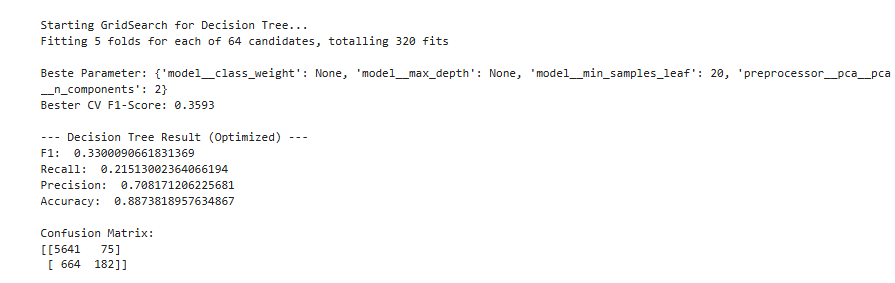

# **5. Chosing best model and predicting aim-data**

In [ ]:
#loading aim-data based on 2nd model (Log Reg)
df_aim = pd.read_csv('features_aim.csv')

#copy of original dataframe
df_results = df_aim.copy()

#adding feature in AIM-Set (so same numbers as Trainset!)
df_results['MilesPerYear'] = df_results['VehOdo'] / np.maximum(df_results['VehicleAge'], 1)

#prediction based [1: bad car, 0: good car]
predictions_aim = pipeline_lr.predict(df_results)
    
#adding probability [%]
probs_aim = pipeline_lr.predict_proba(df_results)[:, 1]

#writing results into a copy of original dataframe
df_results['Prediction_BadBuy'] = predictions_aim
df_results['Risk_Score'] = probs_aim # probability risk-score

# statistics of predictions
n_bad = predictions_aim.sum()
print("-" * 40)
print(f"Result ('features_aim.csv'):")
print(f"- count of all cars: {len(df_results)}")
print(f"- marked as bad buy: {n_bad} ({n_bad/len(df_results):.1%})")
print("-" * 40)

# saving results
output_filename = 'predictions_aim.csv'
df_results.to_csv(output_filename, index=False)
print(f"File saved as: '{output_filename}'")

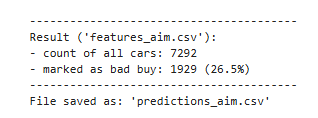